<a href="https://colab.research.google.com/github/Asertigi/task13/blob/main/task13_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этой домашке задания независимы

# Dropout (2 балла)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
input_size = 784
num_classes = 10
batch_size = 128

train_dataset = dsets.MNIST(root='./MNIST/',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.MNIST(root='./MNIST/',
                                  train=False,
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [3]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []


    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, opt, batchsize=batch_size)

        val_loss, val_acc = test(model)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

In [4]:
def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)

        output = model(data)
        loss = F.nll_loss(output, target).cpu()

        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean((pred == y_batch).numpy())
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

In [5]:
def train_epoch(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)

        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output, 1)[1].data.numpy()
        acc = np.mean((pred == y_batch).numpy())
        acc_log.append(acc)

        loss = F.nll_loss(output, target).cpu()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

Создайте простейшую однослойную модель - однослойную полносвязную сеть и обучите ее. Поскольку мнист это задача классификации, не забудте сделать последним слоем логсофтмакс для псевдовероятности.

In [31]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

model = nn.Sequential(
    Flatten(),
    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim=1)
    )

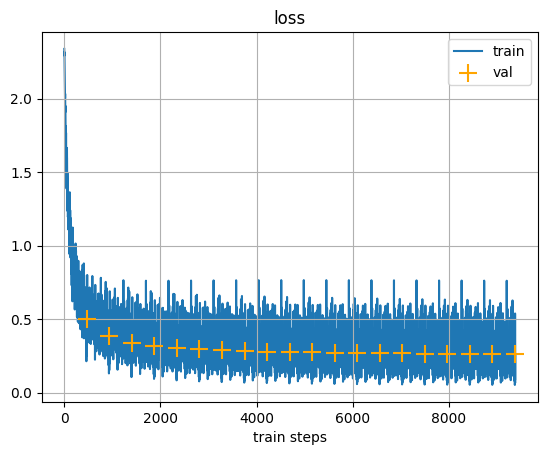

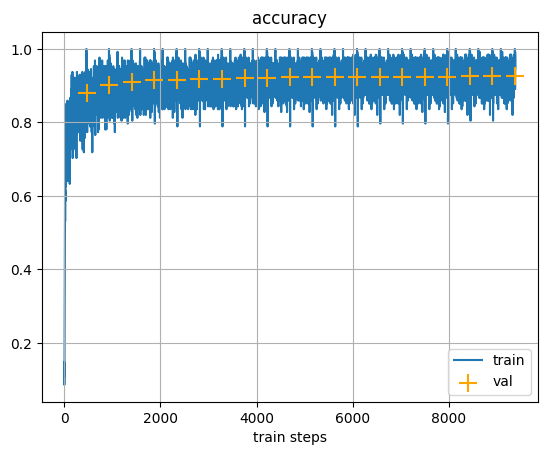

In [7]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 20)

Параметром обученной нейросети является матрица весов, в которой каждому классу соответствует один из 784-мерных столбцов. Их можно представить как двумерные изображения 28-28.

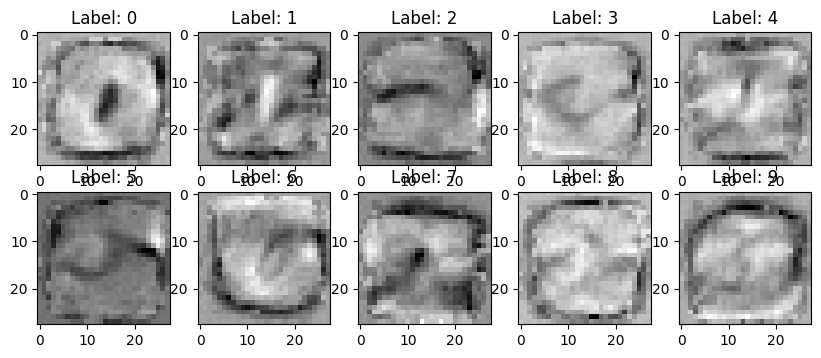

In [8]:
weights = list(model.parameters())[0].data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

Добавьте Dropout-слой в архитектуру сети, проведите оптимизацию с параметрами, заданными ранее, визуализируйте обученные веса. Есть ли разница между весами, обученными с Dropout и без него? Параметр Dropout возьмите равным 0.7

In [9]:
class DropoutLayer(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, input):
        if self.training:
            #code here, здесь нужно создать тензор из биномиального распределения
            dropout_factor = torch.bernoulli(torch.full(input.shape, 1 - self.p)).to(input.device)
        else:
            #code here, здесь тензоры не нужны
            #dropout_factor =
            return input
        return input * dropout_factor / (1 - self.p) #примените дропаут слой, смотрите torch.mul

In [10]:
p = 0.7

modelDp = nn.Sequential(
    Flatten(),
    DropoutLayer(p),

    nn.Linear(input_size, num_classes),
    nn.LogSoftmax(dim = 1)
    )

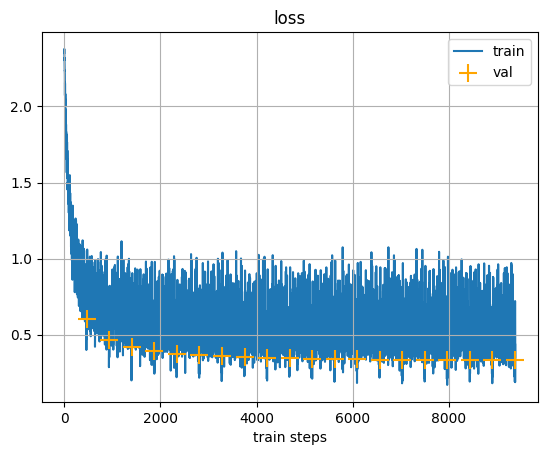

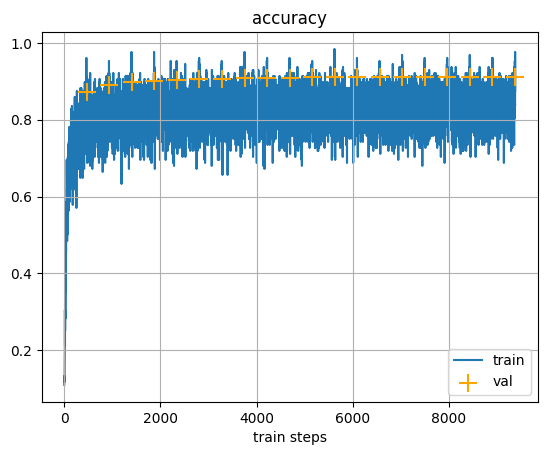

In [11]:
opt = torch.optim.Adam(modelDp.parameters(), lr=0.0005)
train(modelDp, opt, 20)

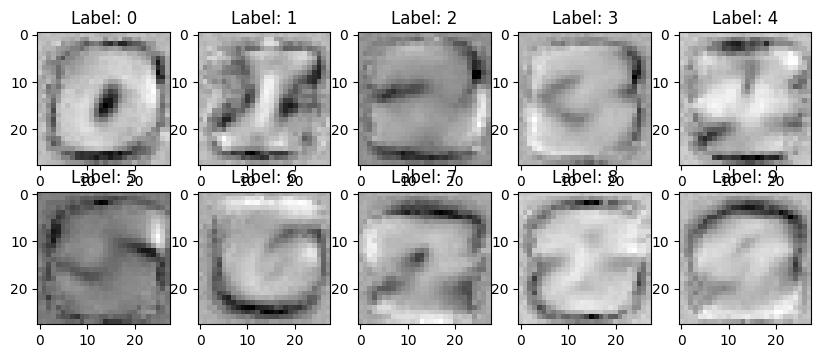

In [12]:
weights = list(modelDp.parameters())[0].data.numpy()
plt.figure(figsize=[10, 10])
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.title("Label: %i" % i)
    plt.imshow(weights[i].reshape([28, 28]), cmap='gray');

# Metric Learning (3 балла)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data.sampler import Sampler, BatchSampler
from torch.nn.modules.loss import MSELoss

Contrastive Loss - одна из самых популярных функций потерь для metric learning. Contrastive Loss получает на вход пару векторов $x_i$ и $x_j$ и метку $y_{ij}$, причем $y_{ij} = 0$, если объекты "похожи" (принадлежат одному классу), и $y_{ij} = 1$, если объекты "различны" (принадлежат различным классам). Формально определим Contrastive Loss следующим образом:

$$
L(x_i, x_j, y_{ij}) = (1 - y_{ij})\|x_i - x_j\|^2 + y_{ij}max(0, m - \|x_i - x_j\|^2)
$$

где $m$ - гиперпараметр (его можно взять равным единице).

Вместо того, чтобы формировать обучающее множество из всевозможных пар, можно поступить проще: будем пропускать батч из $N$ обучаюших изображений через сеть (тем самым получая соответствующие векторы $x$), а значение лосса вычислять как среднее значение функции $L$ на всех парах в этом батче. Тогда в обучении на каждом батче участвует $\frac{N(N-1)}{2}$ пар, что существенно ускоряет сходимость на практике. Реализуйте предложенный вариант Contrastive Loss.

In [14]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x, y):
        batch_size = x.size(0)

        x = x.unsqueeze(1)
        xnew = x.transpose(0, 1)

        distances = torch.norm(x - xnew, dim=2)

        ynew = y.unsqueeze(0) == y.unsqueeze(1)
        ynew = ynew.float()

        loss_similar = ynew * torch.pow(distances, 2)
        loss_dissimilar = (1 - ynew) * torch.pow(torch.clamp(self.margin - distances, min=0.0), 2)
        loss = torch.mean((loss_similar + loss_dissimilar) / 2)

        return loss


В задачах metric learning, как правило, необходимо, чтобы количества "положительных" и "отрицательных" пар в обучении отличалось несильно. Поэтому в случае большого количества классов случайное формирование батчей неэффективно - в таком случае количество "положительных" пар очень мало. Поэтому будем формировать обучающие батчи размера $N$ следующим образом: будем брать $\frac{N}{2}$ элементов из некоторого класса (они между собой будут формировать "положительные пары"), а оставшиеся $\frac{N}{2}$ элементов будем брать случайно. Таким образом мы гарантируем, что в каждом обучающем батче будет достаточно "положительных" пар.

In [15]:
from collections import defaultdict

В этом задании будем работать с небольшими изображениями одежды из датасета Fashion-MNIST.

In [16]:
class ContrastiveSampler(BatchSampler):
    def __init__(self, batch_size, num_classes, labels):
        self.num_classes = num_classes
        self.imgs_per_class = labels.size()[0] // num_classes
        class2idx = defaultdict(list)
        for i, y in enumerate(labels):
            class2idx[i].append(y)
        self.batch_size = batch_size
        self.class2idx = class2idx
        self.total_samples = len(labels)

    def __iter__(self):
        num_yielded = 0
        while num_yielded < (self.num_classes * self.imgs_per_class):
            batch = []
            base = np.random.randint(0, self.num_classes)
            pos = np.random.choice(self.class2idx[base], size=self.batch_size // 2).tolist()
            neg = np.random.randint(self.total_samples, size=self.batch_size // 2).tolist()
            batch += pos + neg
            num_yielded += self.batch_size
            yield batch

In [17]:
input_size = 784
num_classes = 10
batch_size = 256

contrastive_loss = ContrastiveLoss()

train_dataset = dsets.FashionMNIST(root='.',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='.',
                                  train=False,
                                  transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                           num_classes=num_classes, labels=train_dataset.train_labels),
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_sampler=ContrastiveSampler(batch_size=batch_size,
                                          num_classes=num_classes, labels=test_dataset.test_labels),
                                          shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.68MB/s]


Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Реализуйте сеть несложной архитектуры, содержащую три сверточных слоя из 20 фильтров с макс-пулингом, а также два полносвязных слоя из 128 нейронов. Выход последнего слоя будет подаваться на вход Contrastive Loss.

In [18]:
class Flatten(nn.Module):
    def forward(self, x):

        return x.view(x.size()[0], -1)

class ContrastiveNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 20, kernel_size=4),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(20, 20, kernel_size=4),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(20, 20, kernel_size=4),
            Flatten()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(20 * 1 * 1, 128),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(128, 128),

        )


    def forward(self, x):
        output = self.cnn1(x)
        output = self.fc1(output)
        output = self.fc2(output);
        return output

In [19]:
def train_epoch(model, optimizer):
    loss_log = []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)
        optimizer.zero_grad()
        output = model(data)
        loss = contrastive_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        data = Variable(x_batch)
        target = Variable(y_batch)
        output = model(data)
        loss = contrastive_loss(output, target)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def train(model, opt, n_epochs):
    train_log = []
    val_log = []

    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)

In [20]:
model = ContrastiveNetwork()


Обучите сеть с параметрами, указанными ниже.

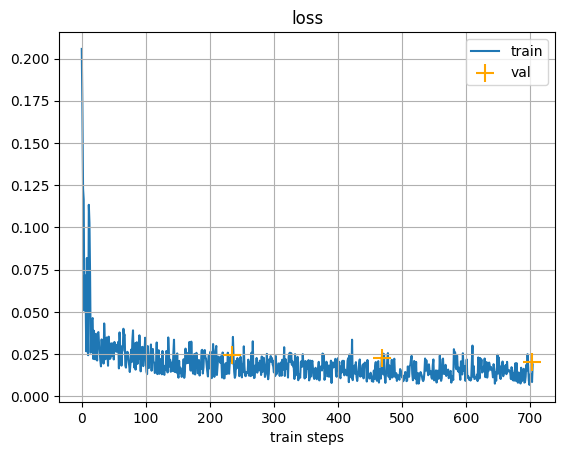

In [21]:
opt = torch.optim.Adam(model.parameters(), lr=0.0005)
train(model, opt, 3)

Извлеките векторные описания тестовых изображений (a.k.a эмбеддинги). У вас должно получиться 10000 128-мерных векторов.

In [22]:
data = test_dataset.test_data
embeddings = model(Variable(data.view(-1, 1, 28, 28)).float())

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


Код ниже демонстрирует поисковую выдачу для трех изображений-запросов. Выдача формируется на основе близости эмбеддингов.

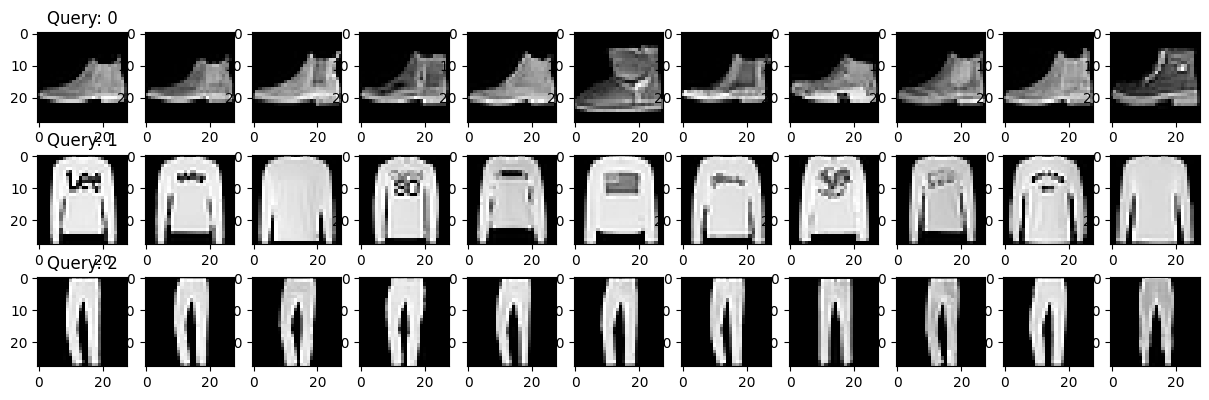

In [23]:
queryCount = 3
queries = embeddings[:queryCount,:].data.numpy()
database = embeddings[queryCount:,:].data.numpy()
plt.figure(figsize=[15, 4.5])
for i in range(queryCount):
    results = np.argsort(np.sum((database-queries[i,:])**2, axis=1))[:10]
    plt.subplot(queryCount, 11, i * 11 + 1)
    plt.title("Query: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    for k in range(10):
        plt.subplot(queryCount, 11, i * 11 + k + 2)
        plt.imshow(test_dataset.test_data[results[k]+queryCount].numpy().reshape([28, 28]), cmap='gray')

# Super-resolution (3 балла)

В этой части вам предстоит реализовать простейшую архитектуру для решения задачи image super-resolution.

In [24]:
input_size = 784
num_classes = 10
batch_size = 256

train_dataset = dsets.MNIST(root='./MNIST/',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='./MNIST/',
                           train=False,
                           transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Мы будем увеличивать изображения размера (14,14) в два раза по каждому измерению. Как правило, перед подачей на вход нейросети изображение низкого разрешения увеличивают до нужного размера билинейной интерполяцией, а нейросеть улучшает результат интерпляции, не меняя пространственные размеры изображения.

Реализуйте нейросеть из трех сверточных слоев, которая будет получать на вход черно-белое изображение и выдавать на выход изображение такого же размера. Нейросеть должна предсказывать добавку, которую необходимо прибавить к полученному на вход изображению низкого качества.

In [25]:
class SuperResolutionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),

        )

        self.cnn2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
        )

        self.cnn3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        new = F.interpolate(x, size=(28, 28), mode='bilinear', align_corners=False)
        output = self.cnn1(new)
        output = self.cnn2(output)
        output = self.cnn3(output)
        return output + new

In [26]:
model = SuperResolutionNetwork()

In [27]:
def low_res_and_high_res(images_batch):
    result = images_batch.clone()
    low_res_transform = transforms.Resize((14,14))
    high_res_transform = transforms.Resize((28,28))
    toTensorTransform = transforms.ToTensor()
    toImageTransform = transforms.ToPILImage()
    for i in range(images_batch.size()[0]):
        result[i] = toTensorTransform(high_res_transform(low_res_transform(toImageTransform(images_batch[i]))))
    return result

def train_epoch(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.float() / 255
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.data.item()
        loss_log.append(loss)
    return loss_log

def test(model):
    loss_log = []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.float() / 255
        data = Variable(low_res_and_high_res(x_batch))
        target = Variable(x_batch)
        output = model(data)
        loss = F.mse_loss(output, target)
        loss = loss.data.item()
        loss_log.append(loss)
    return loss_log

def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    points = np.array(val_history)
    plt.scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def train(model, opt, n_epochs):
    train_log = []
    val_log = []
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, opt, batchsize=batch_size)
        val_loss = test(model)
        train_log.extend(train_loss)
        steps = train_dataset.train_labels.shape[0] / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        clear_output()
        plot_history(train_log, val_log)

Оптимизируйте сеть с параметрами, указанными ниже.

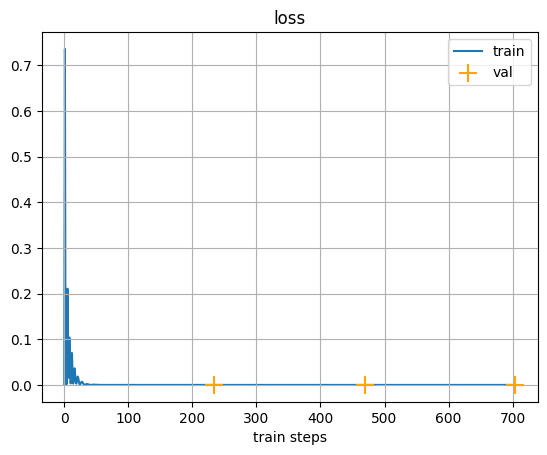

In [28]:
opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.05)
train(model, opt, 3)

In [29]:
test_images = test_dataset.test_data.float() / 255
result_cnn = model(Variable(low_res_and_high_res(test_images.view(-1,1,28,28))))

Код ниже визуализирует исходные изображения (28,28) и реконструкции, полученные с помощью нейросети.
Не удивляйтесь, есть качество реконструкций покажется низким, MSE-loss, не является оптимальным для задачи super-resolution (гораздо лучше работают GANы, расскажу позже).

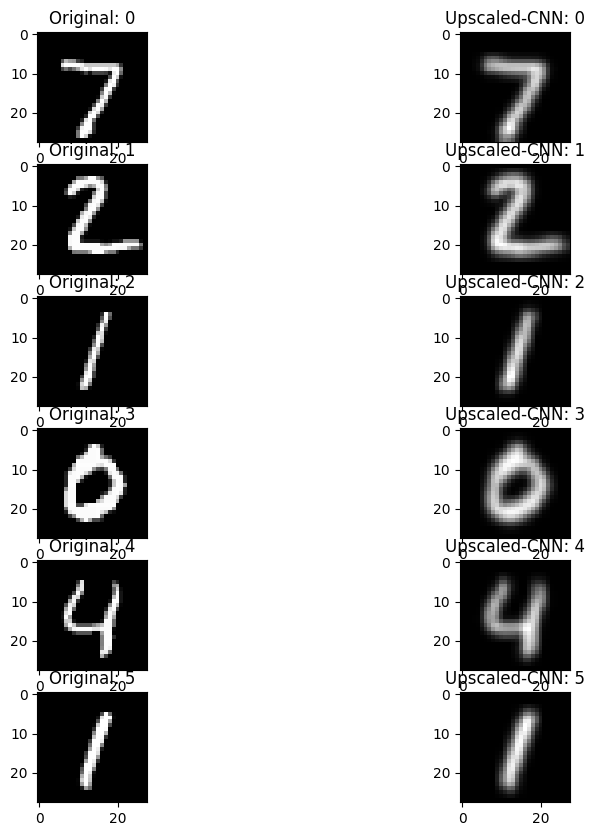

In [30]:
examplesCount = 6
plt.figure(figsize=[10, 10])
for i in range(examplesCount):
    plt.subplot(examplesCount, 2, i * 2 + 1)
    plt.title("Original: %i" % i)
    plt.imshow(test_dataset.test_data[i].numpy().reshape([28, 28]), cmap='gray')
    plt.subplot(examplesCount, 2, i * 2 + 2)
    plt.title("Upscaled-CNN: %i" % i)
    plt.imshow(result_cnn[i].data.numpy().reshape([28, 28]), cmap='gray')